In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [7]:
from GModReLU import GModReLU, GModReLUFunction

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Define transform
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

full_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

from torch.utils.data import random_split

# Split into train and val
train_size = int(0.9 * len(full_train))
val_size = len(full_train) - train_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)


In [9]:
class CNN(nn.Module):
    def __init__(self, activation_fn=nn.ReLU()):
        super().__init__()
        self.activation = activation_fn

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
from ResNet import ResNet18

In [11]:
from collections import defaultdict, deque
from tqdm import tqdm
import numpy as np
import os

def train_and_evaluate(activation, train_loader, val_loader, network_class = CNN, epochs=10, lr=0.001, log_every=100, device='cpu',
                       save_path = None, save_every = 5,
                       logger = None):
    model = network_class(activation).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    logs = defaultdict(list)

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        grad_norms = []
        weight_updates = []
        
        running_loss = deque(maxlen=50)  # For smooth display
        running_acc = deque(maxlen=50)

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for batch_idx, (inputs, labels) in enumerate(pbar):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradients and updates
            total_norm = 0
            weight_update_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    total_norm += p.grad.data.norm(2).item() ** 2
                    weight_update_norm += (lr * p.grad.data).norm(2).item() ** 2

            grad_norms.append(np.sqrt(total_norm))
            weight_updates.append(np.sqrt(weight_update_norm))

            optimizer.step()

            batch_size = inputs.size(0)
            total_loss += loss.item() * batch_size
            total += batch_size

            batch_acc = (outputs.argmax(1) == labels).float().mean().item()
            correct += (outputs.argmax(1) == labels).sum().item()

            if batch_idx % log_every == 0:
                logs['batches'].append({
                    'epoch': epoch,
                    'batch_idx': batch_idx,
                    'loss': loss.item(),
                    'acc': batch_acc,
                    'grad_norm': grad_norms[-1],
                    'weight_update_norm': weight_updates[-1],
                    'samples_seen': total
                })

            # Track running stats for display
            running_loss.append(loss.item())
            running_acc.append(batch_acc)

            if batch_idx % 10 == 0:
                pbar.set_postfix({
                    'loss': f'{np.mean(running_loss):.4f}',
                    'acc': f'{np.mean(running_acc) * 100:.2f}%',
                    'grad_norm': f'{grad_norms[-1]:.2f}'
                })

        logs['train_loss'].append(total_loss / total)
        logs['train_acc'].append(correct / total)
        logs['train_grad_norm'].append(np.mean(grad_norms))
        logs['train_weight_update_norm'].append(np.mean(weight_updates))

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += inputs.size(0)

        logs['val_loss'].append(val_loss / val_total)
        logs['val_acc'].append(val_correct / val_total)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {logs['train_loss'][-1]:.4f} | "
              f"Train Acc: {logs['train_acc'][-1]*100:.2f}% | "
              f"Val Acc: {logs['val_acc'][-1]*100:.2f}%")

        if save_path != None and (epoch % save_every == 0):
            os.makedirs(save_path, exist_ok=True)
            torch.save(model.state_dict(), f"{save_path}/model_epoch_{epoch}.pt")
            
    if save_path != None:
        os.makedirs(save_path, exist_ok=True)
        torch.save(model.state_dict(), f"{save_path}/model_final.pt")
    
    if logger != None:
        logger(("gmodrelu",l,k),logs)
        
    return logs

In [59]:
for i in range(3):
    ReLU_logs = train_and_evaluate(
        torch.nn.ReLU(),
        network_class = ResNet18,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=3,          # or however many you want
        lr=0.001,           # or your preferred LR
        device='cuda' if torch.cuda.is_available() else 'cpu',
        save_path = "./checkpoints/ReLUResNet2",
        save_every = 10,
    )
    insert_log_data("relu",ReLU_logs)

Epoch 1/3 | Train Loss: 1.4885 | Train Acc: 45.57% | Val Acc: 53.90%


Epoch 2/3 | Train Loss: 1.0150 | Train Acc: 63.67% | Val Acc: 68.88%


Epoch 3/3 | Train Loss: 0.8043 | Train Acc: 71.70% | Val Acc: 71.42%


KeyboardInterrupt: 

In [57]:
insert_log_data("relu",ReLU_logs)

In [24]:
GeLU_logs = train_and_evaluate(
    torch.nn.GELU(),
    network_class = ResNet18,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=50,          # or however many you want
    lr=0.0005,           # or your preferred LR
    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_path = "./checkpoints/ReLUResNet2",
    save_every = 10,
)
insert_log_data("gelu",GeLU_logs)

Epoch 1/50 | Train Loss: 1.3680 | Train Acc: 50.04% | Val Acc: 60.44%


Epoch 2/50 | Train Loss: 0.8862 | Train Acc: 68.72% | Val Acc: 69.34%


Epoch 3/50 | Train Loss: 0.6841 | Train Acc: 75.99% | Val Acc: 77.28%


Epoch 4/50 | Train Loss: 0.5723 | Train Acc: 80.19% | Val Acc: 80.26%


Epoch 5/50 | Train Loss: 0.5017 | Train Acc: 82.56% | Val Acc: 83.00%


Epoch 6/50 | Train Loss: 0.4458 | Train Acc: 84.63% | Val Acc: 83.14%


Epoch 7/50 | Train Loss: 0.4007 | Train Acc: 86.24% | Val Acc: 84.84%


Epoch 8/50 | Train Loss: 0.3624 | Train Acc: 87.48% | Val Acc: 84.56%


Epoch 9/50 | Train Loss: 0.3311 | Train Acc: 88.46% | Val Acc: 87.24%


Epoch 10/50 | Train Loss: 0.3015 | Train Acc: 89.62% | Val Acc: 86.52%


Epoch 11/50 | Train Loss: 0.2802 | Train Acc: 90.31% | Val Acc: 88.32%


Epoch 12/50 | Train Loss: 0.2560 | Train Acc: 91.14% | Val Acc: 88.38%


Epoch 13/50 | Train Loss: 0.2377 | Train Acc: 91.76% | Val Acc: 89.56%


Epoch 14/50 | Train Loss: 0.2151 | Train Acc: 92.47% | Val Acc: 88.80%


Epoch 15/50 | Train Loss: 0.2021 | Train Acc: 92.90% | Val Acc: 89.80%


Epoch 16/50 | Train Loss: 0.1867 | Train Acc: 93.56% | Val Acc: 89.32%


Epoch 17/50 | Train Loss: 0.1707 | Train Acc: 94.00% | Val Acc: 89.90%


Epoch 18/50 | Train Loss: 0.1603 | Train Acc: 94.31% | Val Acc: 90.78%


Epoch 19/50 | Train Loss: 0.1496 | Train Acc: 94.77% | Val Acc: 90.24%


Epoch 20/50 | Train Loss: 0.1392 | Train Acc: 95.04% | Val Acc: 90.22%


Epoch 21/50 | Train Loss: 0.1278 | Train Acc: 95.47% | Val Acc: 90.50%


Epoch 22/50 | Train Loss: 0.1195 | Train Acc: 95.82% | Val Acc: 90.68%


Epoch 23/50 | Train Loss: 0.1108 | Train Acc: 96.06% | Val Acc: 90.68%


Epoch 24/50 | Train Loss: 0.1034 | Train Acc: 96.33% | Val Acc: 90.40%


Epoch 25/50 | Train Loss: 0.0990 | Train Acc: 96.46% | Val Acc: 90.88%


Epoch 26/50 | Train Loss: 0.0928 | Train Acc: 96.72% | Val Acc: 91.06%


Epoch 27/50 | Train Loss: 0.0855 | Train Acc: 96.96% | Val Acc: 91.18%


Epoch 28/50 | Train Loss: 0.0856 | Train Acc: 96.98% | Val Acc: 90.64%


Epoch 29/50 | Train Loss: 0.0810 | Train Acc: 97.10% | Val Acc: 90.88%


Epoch 30/50 | Train Loss: 0.0702 | Train Acc: 97.57% | Val Acc: 91.62%


Epoch 31/50 | Train Loss: 0.0693 | Train Acc: 97.51% | Val Acc: 91.98%


Epoch 32/50 | Train Loss: 0.0672 | Train Acc: 97.64% | Val Acc: 90.38%


Epoch 33/50 | Train Loss: 0.0633 | Train Acc: 97.75% | Val Acc: 92.00%


Epoch 34/50 | Train Loss: 0.0593 | Train Acc: 97.87% | Val Acc: 91.82%


Epoch 35/50 | Train Loss: 0.0565 | Train Acc: 98.03% | Val Acc: 92.12%


Epoch 36/50 | Train Loss: 0.0555 | Train Acc: 98.11% | Val Acc: 91.76%


Epoch 37/50 | Train Loss: 0.0543 | Train Acc: 98.10% | Val Acc: 92.16%


Epoch 38/50 | Train Loss: 0.0505 | Train Acc: 98.26% | Val Acc: 92.02%


Epoch 39/50 | Train Loss: 0.0537 | Train Acc: 98.18% | Val Acc: 92.34%


Epoch 40/50 | Train Loss: 0.0467 | Train Acc: 98.32% | Val Acc: 91.96%


Epoch 41/50 | Train Loss: 0.0450 | Train Acc: 98.46% | Val Acc: 91.88%


Epoch 42/50 | Train Loss: 0.0461 | Train Acc: 98.40% | Val Acc: 91.86%


Epoch 43/50 | Train Loss: 0.0421 | Train Acc: 98.55% | Val Acc: 91.62%


Epoch 44/50 | Train Loss: 0.0405 | Train Acc: 98.52% | Val Acc: 91.84%


Epoch 45/50 | Train Loss: 0.0387 | Train Acc: 98.68% | Val Acc: 91.86%


Epoch 46/50 | Train Loss: 0.0383 | Train Acc: 98.67% | Val Acc: 91.68%


Epoch 47/50 | Train Loss: 0.0433 | Train Acc: 98.53% | Val Acc: 91.80%


Epoch 48/50 | Train Loss: 0.0348 | Train Acc: 98.79% | Val Acc: 92.38%


Epoch 49/50 | Train Loss: 0.0375 | Train Acc: 98.68% | Val Acc: 91.98%


Epoch 50/50 | Train Loss: 0.0333 | Train Acc: 98.82% | Val Acc: 91.58%


In [93]:
l_val = 0.00
k_val = 0.00
# l_val = 0.03
# k_val = 0.001
for i in range(4):
    GModReLU_logs = train_and_evaluate(
        GModReLU(l=l_val,k=k_val),
        network_class = ResNet18,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=3,          # or however many you want
        lr=0.001,           # or your preferred LR
        device='cuda' if torch.cuda.is_available() else 'cpu',
        # save_path = "./checkpoints/ReLUResNet2",
        # save_every = 10,
    )
    insert_log_data(("gmodrelu",l_val,k_val),GModReLU_logs)

Epoch 1/3 | Train Loss: 1.5059 | Train Acc: 44.87% | Val Acc: 58.60%


Epoch 2/3 | Train Loss: 1.0062 | Train Acc: 64.12% | Val Acc: 63.52%


Epoch 3/3 | Train Loss: 0.7927 | Train Acc: 72.06% | Val Acc: 74.52%


Epoch 1/3 | Train Loss: 1.5043 | Train Acc: 44.30% | Val Acc: 54.62%


Epoch 2/3 | Train Loss: 1.0391 | Train Acc: 62.87% | Val Acc: 64.44%


Epoch 3/3 | Train Loss: 0.8174 | Train Acc: 71.32% | Val Acc: 74.96%


Epoch 1/3 | Train Loss: 1.4458 | Train Acc: 46.84% | Val Acc: 53.24%


Epoch 2/3 | Train Loss: 0.9522 | Train Acc: 66.13% | Val Acc: 64.72%


Epoch 3/3 | Train Loss: 0.7413 | Train Acc: 74.04% | Val Acc: 75.42%


Epoch 1/3 | Train Loss: 1.5466 | Train Acc: 42.90% | Val Acc: 47.44%


Epoch 2/3 | Train Loss: 1.0715 | Train Acc: 61.40% | Val Acc: 65.04%


Epoch 3/3 | Train Loss: 0.8447 | Train Acc: 70.22% | Val Acc: 71.44%


In [13]:
log_data = dict()
def insert_log_data(key,data):
    if key not in log_data:
        log_data[key] = []
    log_data[key].append(data)

In [15]:
insert_log_data("relu",ReLU_logs)

In [128]:
logs_gmodrelus = [] 
l_vals = np.linspace(0.001,0.02,13)
for i in range(l_vals.shape[0]):
    l_val = l_vals[i]
    k_val = 0.001
    print(f"Training {i}, l = {l_val}, k = {k_val}")
    log = train_and_evaluate(
        GModReLU(l=l_val,k=k_val),
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=10,          # or however many you want
        lr=0.001,           # or your preferred LR
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    insert_log_data(("gmodrelu",l_val,k_val),log)
    logs_gmodrelus.append(log)

Training 0, l = 0.04, k = 0.001


Epoch 1/10 | Train Loss: 1.3482 | Train Acc: 51.08% | Val Acc: 61.46%


Epoch 2/10 | Train Loss: 0.9263 | Train Acc: 67.71% | Val Acc: 69.82%


Epoch 3/10 | Train Loss: 0.7802 | Train Acc: 72.99% | Val Acc: 71.66%


Epoch 4/10 | Train Loss: 0.6861 | Train Acc: 76.39% | Val Acc: 74.34%


Epoch 5/10 | Train Loss: 0.6127 | Train Acc: 78.99% | Val Acc: 75.24%


Epoch 6/10 | Train Loss: 0.5403 | Train Acc: 81.44% | Val Acc: 74.70%


Epoch 7/10 | Train Loss: 0.4846 | Train Acc: 83.30% | Val Acc: 76.56%


Epoch 8/10 | Train Loss: 0.4267 | Train Acc: 85.22% | Val Acc: 76.96%


Epoch 9/10 | Train Loss: 0.3683 | Train Acc: 87.27% | Val Acc: 76.78%


Epoch 10/10 | Train Loss: 0.3229 | Train Acc: 88.78% | Val Acc: 76.50%
Training 1, l = 0.042333333333333334, k = 0.001


Epoch 1/10 | Train Loss: 1.3819 | Train Acc: 49.69% | Val Acc: 61.96%


Epoch 2/10 | Train Loss: 0.9649 | Train Acc: 66.13% | Val Acc: 68.46%


Epoch 3/10 | Train Loss: 0.8183 | Train Acc: 71.50% | Val Acc: 69.58%


Epoch 4/10 | Train Loss: 0.7200 | Train Acc: 75.04% | Val Acc: 72.96%


Epoch 5/10 | Train Loss: 0.6484 | Train Acc: 77.53% | Val Acc: 72.78%


Epoch 6/10 | Train Loss: 0.5823 | Train Acc: 79.89% | Val Acc: 75.50%


Epoch 7/10 | Train Loss: 0.5181 | Train Acc: 82.18% | Val Acc: 75.44%


Epoch 8/10 | Train Loss: 0.4689 | Train Acc: 83.86% | Val Acc: 76.94%


Epoch 9/10 | Train Loss: 0.4197 | Train Acc: 85.51% | Val Acc: 77.54%


Epoch 10/10 | Train Loss: 0.3727 | Train Acc: 87.18% | Val Acc: 76.04%
Training 2, l = 0.04466666666666667, k = 0.001


Epoch 1/10 | Train Loss: 1.3818 | Train Acc: 49.77% | Val Acc: 61.24%


Epoch 2/10 | Train Loss: 0.9594 | Train Acc: 66.45% | Val Acc: 67.84%


Epoch 3/10 | Train Loss: 0.8127 | Train Acc: 71.86% | Val Acc: 70.62%


Epoch 4/10 | Train Loss: 0.7229 | Train Acc: 75.02% | Val Acc: 72.32%


Epoch 5/10 | Train Loss: 0.6520 | Train Acc: 77.55% | Val Acc: 73.38%


Epoch 6/10 | Train Loss: 0.5846 | Train Acc: 79.80% | Val Acc: 75.14%


Epoch 7/10 | Train Loss: 0.5202 | Train Acc: 82.11% | Val Acc: 75.60%


Epoch 8/10 | Train Loss: 0.4774 | Train Acc: 83.55% | Val Acc: 75.30%


Epoch 9/10 | Train Loss: 0.4307 | Train Acc: 85.11% | Val Acc: 77.46%


Epoch 10/10 | Train Loss: 0.3822 | Train Acc: 86.97% | Val Acc: 77.84%
Training 3, l = 0.047, k = 0.001


Epoch 1/10 | Train Loss: 1.3845 | Train Acc: 49.73% | Val Acc: 60.04%


Epoch 2/10 | Train Loss: 0.9580 | Train Acc: 66.44% | Val Acc: 68.24%


Epoch 3/10 | Train Loss: 0.8111 | Train Acc: 72.03% | Val Acc: 70.96%


Epoch 4/10 | Train Loss: 0.7254 | Train Acc: 75.00% | Val Acc: 70.52%


Epoch 5/10 | Train Loss: 0.6602 | Train Acc: 77.36% | Val Acc: 70.32%


Epoch 6/10 | Train Loss: 0.6044 | Train Acc: 79.20% | Val Acc: 73.66%


Epoch 7/10 | Train Loss: 0.5519 | Train Acc: 81.13% | Val Acc: 74.74%


Epoch 8/10 | Train Loss: 0.5080 | Train Acc: 82.54% | Val Acc: 75.54%


Epoch 9/10 | Train Loss: 0.4529 | Train Acc: 84.43% | Val Acc: 75.78%


Epoch 10/10 | Train Loss: 0.4216 | Train Acc: 85.42% | Val Acc: 75.10%
Training 4, l = 0.04933333333333333, k = 0.001


Epoch 1/10 | Train Loss: 1.4126 | Train Acc: 48.36% | Val Acc: 58.84%


Epoch 2/10 | Train Loss: 1.0122 | Train Acc: 64.46% | Val Acc: 65.04%


Epoch 3/10 | Train Loss: 0.8649 | Train Acc: 70.17% | Val Acc: 68.32%


Epoch 4/10 | Train Loss: 0.7778 | Train Acc: 73.24% | Val Acc: 71.28%


Epoch 5/10 | Train Loss: 0.7084 | Train Acc: 75.75% | Val Acc: 71.42%


Epoch 6/10 | Train Loss: 0.6537 | Train Acc: 77.67% | Val Acc: 73.84%


Epoch 7/10 | Train Loss: 0.5917 | Train Acc: 79.79% | Val Acc: 74.62%


Epoch 8/10 | Train Loss: 0.5559 | Train Acc: 80.82% | Val Acc: 74.16%


Epoch 9/10 | Train Loss: 0.5088 | Train Acc: 82.58% | Val Acc: 76.28%


Epoch 10/10 | Train Loss: 0.4646 | Train Acc: 84.01% | Val Acc: 75.64%
Training 5, l = 0.051666666666666666, k = 0.001


Epoch 1/10 | Train Loss: 1.3710 | Train Acc: 50.33% | Val Acc: 62.48%


Epoch 2/10 | Train Loss: 0.9621 | Train Acc: 66.33% | Val Acc: 66.04%


Epoch 3/10 | Train Loss: 0.8315 | Train Acc: 71.00% | Val Acc: 68.90%


Epoch 4/10 | Train Loss: 0.7506 | Train Acc: 74.05% | Val Acc: 72.48%


Epoch 5/10 | Train Loss: 0.6879 | Train Acc: 76.36% | Val Acc: 73.12%


Epoch 6/10 | Train Loss: 0.6380 | Train Acc: 78.20% | Val Acc: 72.54%


Epoch 7/10 | Train Loss: 0.5951 | Train Acc: 79.48% | Val Acc: 75.40%


Epoch 8/10 | Train Loss: 0.5480 | Train Acc: 81.15% | Val Acc: 73.12%


Epoch 9/10 | Train Loss: 0.5163 | Train Acc: 82.28% | Val Acc: 74.96%


Epoch 10/10 | Train Loss: 0.4725 | Train Acc: 83.91% | Val Acc: 74.82%
Training 6, l = 0.054000000000000006, k = 0.001


Epoch 1/10 | Train Loss: 1.3911 | Train Acc: 49.67% | Val Acc: 58.84%


Epoch 2/10 | Train Loss: 0.9943 | Train Acc: 65.31% | Val Acc: 63.22%


Epoch 3/10 | Train Loss: 0.8621 | Train Acc: 70.38% | Val Acc: 70.14%


Epoch 4/10 | Train Loss: 0.7842 | Train Acc: 72.85% | Val Acc: 71.12%


Epoch 5/10 | Train Loss: 0.7309 | Train Acc: 74.77% | Val Acc: 70.74%


Epoch 6/10 | Train Loss: 0.6805 | Train Acc: 76.75% | Val Acc: 70.86%


Epoch 7/10 | Train Loss: 0.6361 | Train Acc: 78.20% | Val Acc: 71.46%


Epoch 8/10 | Train Loss: 0.5967 | Train Acc: 79.41% | Val Acc: 74.34%


Epoch 9/10 | Train Loss: 0.5553 | Train Acc: 81.11% | Val Acc: 74.30%


Epoch 10/10 | Train Loss: 0.5266 | Train Acc: 81.94% | Val Acc: 74.56%
Training 7, l = 0.05633333333333333, k = 0.001


Epoch 1/10 | Train Loss: 1.3934 | Train Acc: 49.43% | Val Acc: 58.96%


Epoch 2/10 | Train Loss: 1.0115 | Train Acc: 64.67% | Val Acc: 64.00%


Epoch 3/10 | Train Loss: 0.8773 | Train Acc: 69.72% | Val Acc: 66.60%


Epoch 4/10 | Train Loss: 0.7988 | Train Acc: 72.59% | Val Acc: 70.84%


Epoch 5/10 | Train Loss: 0.7458 | Train Acc: 74.27% | Val Acc: 73.14%


Epoch 6/10 | Train Loss: 0.6948 | Train Acc: 76.10% | Val Acc: 70.64%


Epoch 7/10 | Train Loss: 0.6532 | Train Acc: 77.58% | Val Acc: 74.08%


Epoch 8/10 | Train Loss: 0.6122 | Train Acc: 79.13% | Val Acc: 70.80%


Epoch 9/10 | Train Loss: 0.5851 | Train Acc: 79.76% | Val Acc: 72.12%


Epoch 10/10 | Train Loss: 0.5492 | Train Acc: 81.11% | Val Acc: 72.44%
Training 8, l = 0.05866666666666667, k = 0.001


Epoch 1/10 | Train Loss: 1.3912 | Train Acc: 49.73% | Val Acc: 61.62%


Epoch 2/10 | Train Loss: 1.0158 | Train Acc: 64.51% | Val Acc: 61.54%


Epoch 3/10 | Train Loss: 0.8879 | Train Acc: 69.44% | Val Acc: 70.24%


Epoch 4/10 | Train Loss: 0.8095 | Train Acc: 72.31% | Val Acc: 69.70%


Epoch 5/10 | Train Loss: 0.7587 | Train Acc: 74.05% | Val Acc: 68.28%


Epoch 6/10 | Train Loss: 0.7227 | Train Acc: 75.32% | Val Acc: 71.18%


Epoch 7/10 | Train Loss: 0.6741 | Train Acc: 77.08% | Val Acc: 72.08%


Epoch 8/10 | Train Loss: 0.6386 | Train Acc: 78.23% | Val Acc: 72.92%


Epoch 9/10 | Train Loss: 0.6039 | Train Acc: 79.39% | Val Acc: 72.20%


Epoch 10/10 | Train Loss: 0.5855 | Train Acc: 79.98% | Val Acc: 70.16%
Training 9, l = 0.061, k = 0.001


Epoch 1/10 | Train Loss: 1.4017 | Train Acc: 49.35% | Val Acc: 58.58%


Epoch 2/10 | Train Loss: 1.0297 | Train Acc: 63.99% | Val Acc: 66.00%


Epoch 3/10 | Train Loss: 0.9045 | Train Acc: 68.89% | Val Acc: 67.38%


Epoch 4/10 | Train Loss: 0.8393 | Train Acc: 71.13% | Val Acc: 66.94%


Epoch 5/10 | Train Loss: 0.7852 | Train Acc: 72.89% | Val Acc: 67.80%


Epoch 6/10 | Train Loss: 0.7383 | Train Acc: 74.80% | Val Acc: 71.46%


Epoch 7/10 | Train Loss: 0.7049 | Train Acc: 75.85% | Val Acc: 68.82%


Epoch 8/10 | Train Loss: 0.6777 | Train Acc: 76.59% | Val Acc: 65.96%


Epoch 9/10 | Train Loss: 0.6442 | Train Acc: 77.93% | Val Acc: 70.62%


Epoch 10/10 | Train Loss: 0.6119 | Train Acc: 79.00% | Val Acc: 71.64%
Training 10, l = 0.06333333333333334, k = 0.001


Epoch 1/10 | Train Loss: 1.4156 | Train Acc: 48.73% | Val Acc: 59.30%


Epoch 2/10 | Train Loss: 1.0349 | Train Acc: 64.12% | Val Acc: 63.96%


Epoch 3/10 | Train Loss: 0.9187 | Train Acc: 68.22% | Val Acc: 65.04%


Epoch 4/10 | Train Loss: 0.8574 | Train Acc: 70.49% | Val Acc: 68.04%


Epoch 5/10 | Train Loss: 0.8086 | Train Acc: 72.07% | Val Acc: 70.70%


Epoch 6/10 | Train Loss: 0.7757 | Train Acc: 73.24% | Val Acc: 71.18%


Epoch 7/10 | Train Loss: 0.7346 | Train Acc: 74.56% | Val Acc: 69.08%


Epoch 8/10 | Train Loss: 0.7146 | Train Acc: 75.42% | Val Acc: 70.82%


Epoch 9/10 | Train Loss: 0.6837 | Train Acc: 76.44% | Val Acc: 67.84%


Epoch 10/10 | Train Loss: 0.6557 | Train Acc: 77.43% | Val Acc: 69.96%
Training 11, l = 0.06566666666666666, k = 0.001


Epoch 1/10 | Train Loss: 1.4055 | Train Acc: 49.02% | Val Acc: 59.38%


Epoch 2/10 | Train Loss: 1.0547 | Train Acc: 63.28% | Val Acc: 63.36%


Epoch 3/10 | Train Loss: 0.9463 | Train Acc: 67.20% | Val Acc: 64.34%


Epoch 4/10 | Train Loss: 0.8803 | Train Acc: 69.76% | Val Acc: 65.82%


Epoch 5/10 | Train Loss: 0.8430 | Train Acc: 70.83% | Val Acc: 67.52%


Epoch 6/10 | Train Loss: 0.7985 | Train Acc: 72.35% | Val Acc: 65.94%


Epoch 7/10 | Train Loss: 0.7704 | Train Acc: 73.61% | Val Acc: 71.30%


Epoch 8/10 | Train Loss: 0.7370 | Train Acc: 74.65% | Val Acc: 68.08%


Epoch 9/10 | Train Loss: 0.7098 | Train Acc: 75.64% | Val Acc: 69.08%


Epoch 10/10 | Train Loss: 0.6858 | Train Acc: 76.30% | Val Acc: 68.12%
Training 12, l = 0.068, k = 0.001


Epoch 1/10 | Train Loss: 1.3924 | Train Acc: 49.81% | Val Acc: 51.34%


Epoch 2/10 | Train Loss: 1.0603 | Train Acc: 63.16% | Val Acc: 64.62%


Epoch 3/10 | Train Loss: 0.9442 | Train Acc: 67.51% | Val Acc: 63.18%


Epoch 4/10 | Train Loss: 0.8887 | Train Acc: 69.53% | Val Acc: 66.74%


Epoch 5/10 | Train Loss: 0.8484 | Train Acc: 70.99% | Val Acc: 64.92%


Epoch 6/10 | Train Loss: 0.8141 | Train Acc: 72.06% | Val Acc: 63.52%


Epoch 7/10 | Train Loss: 0.7914 | Train Acc: 72.86% | Val Acc: 69.26%


Epoch 8/10 | Train Loss: 0.7649 | Train Acc: 73.61% | Val Acc: 68.60%


Epoch 9/10 | Train Loss: 0.7430 | Train Acc: 74.57% | Val Acc: 70.64%


Epoch 10/10 | Train Loss: 0.7253 | Train Acc: 74.88% | Val Acc: 68.20%


In [83]:

for l_val in [0.001,0.005,0.01]:
    k_vals = np.exp(np.linspace(math.log(1.e-10),math.log(1.e-03),9))
    for i in range(k_vals.shape[0]):
        log = train_and_evaluate(
            GModReLU(l=l_val,k=k_vals[i]),
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=3,          # or however many you want
            lr=0.001,           # or your preferred LR
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )
        insert_log_data(("gmodrelu",l_val,k_vals[i]),log)

Epoch 1/3 | Train Loss: 1.5582 | Train Acc: 42.86% | Val Acc: 52.00%


Epoch 2/3 | Train Loss: 1.1800 | Train Acc: 57.66% | Val Acc: 59.20%


Epoch 3/3 | Train Loss: 1.0036 | Train Acc: 64.24% | Val Acc: 66.66%


Epoch 1/3 | Train Loss: 1.5717 | Train Acc: 42.65% | Val Acc: 51.64%


Epoch 2/3 | Train Loss: 1.1755 | Train Acc: 57.93% | Val Acc: 62.16%


Epoch 3/3 | Train Loss: 0.9956 | Train Acc: 64.90% | Val Acc: 66.88%


Epoch 1/3 | Train Loss: 1.5773 | Train Acc: 42.16% | Val Acc: 51.84%


Epoch 2/3 | Train Loss: 1.2096 | Train Acc: 56.60% | Val Acc: 58.68%


Epoch 3/3 | Train Loss: 1.0212 | Train Acc: 63.43% | Val Acc: 63.40%


Epoch 1/3 | Train Loss: 1.5422 | Train Acc: 43.57% | Val Acc: 49.74%


Epoch 2/3 | Train Loss: 1.1700 | Train Acc: 58.23% | Val Acc: 63.12%


Epoch 3/3 | Train Loss: 0.9891 | Train Acc: 64.92% | Val Acc: 66.24%


Epoch 1/3 | Train Loss: 1.5595 | Train Acc: 42.95% | Val Acc: 53.54%


Epoch 2/3 | Train Loss: 1.1627 | Train Acc: 58.39% | Val Acc: 62.06%


Epoch 3/3 | Train Loss: 0.9892 | Train Acc: 65.08% | Val Acc: 67.90%


Epoch 1/3 | Train Loss: 1.5377 | Train Acc: 44.14% | Val Acc: 53.50%


Epoch 2/3 | Train Loss: 1.1420 | Train Acc: 59.41% | Val Acc: 62.10%


Epoch 3/3 | Train Loss: 0.9719 | Train Acc: 65.79% | Val Acc: 67.30%


Epoch 1/3 | Train Loss: 1.5798 | Train Acc: 42.17% | Val Acc: 51.26%


Epoch 2/3 | Train Loss: 1.2035 | Train Acc: 56.59% | Val Acc: 60.16%


Epoch 3/3 | Train Loss: 1.0231 | Train Acc: 63.61% | Val Acc: 65.98%


Epoch 1/3 | Train Loss: 1.5644 | Train Acc: 43.01% | Val Acc: 50.96%


Epoch 2/3 | Train Loss: 1.1677 | Train Acc: 58.29% | Val Acc: 62.20%


Epoch 3/3 | Train Loss: 1.0016 | Train Acc: 64.71% | Val Acc: 63.68%


Epoch 1/3 | Train Loss: 1.5389 | Train Acc: 43.65% | Val Acc: 53.12%


Epoch 2/3 | Train Loss: 1.1524 | Train Acc: 58.79% | Val Acc: 59.56%


Epoch 3/3 | Train Loss: 0.9934 | Train Acc: 64.93% | Val Acc: 67.00%


Epoch 1/3 | Train Loss: 1.5606 | Train Acc: 42.94% | Val Acc: 50.82%


Epoch 2/3 | Train Loss: 1.1734 | Train Acc: 58.29% | Val Acc: 62.48%


Epoch 3/3 | Train Loss: 0.9914 | Train Acc: 64.87% | Val Acc: 66.92%


Epoch 1/3 | Train Loss: 1.5583 | Train Acc: 43.28% | Val Acc: 52.00%


Epoch 2/3 | Train Loss: 1.1712 | Train Acc: 58.07% | Val Acc: 61.60%


Epoch 3/3 | Train Loss: 0.9941 | Train Acc: 64.97% | Val Acc: 67.44%


Epoch 1/3 | Train Loss: 1.5785 | Train Acc: 42.32% | Val Acc: 51.92%


Epoch 2/3 | Train Loss: 1.1843 | Train Acc: 57.77% | Val Acc: 61.56%


Epoch 3/3 | Train Loss: 1.0136 | Train Acc: 63.92% | Val Acc: 67.74%


Epoch 1/3 | Train Loss: 1.5739 | Train Acc: 42.00% | Val Acc: 51.66%


Epoch 2/3 | Train Loss: 1.1995 | Train Acc: 56.99% | Val Acc: 60.92%


Epoch 3/3 | Train Loss: 1.0130 | Train Acc: 63.99% | Val Acc: 66.06%


Epoch 1/3 | Train Loss: 1.5545 | Train Acc: 42.83% | Val Acc: 54.12%


Epoch 2/3 | Train Loss: 1.1824 | Train Acc: 57.71% | Val Acc: 62.50%


Epoch 3/3 | Train Loss: 1.0155 | Train Acc: 63.93% | Val Acc: 67.28%


Epoch 1/3 | Train Loss: 1.5493 | Train Acc: 43.45% | Val Acc: 53.34%


Epoch 2/3 | Train Loss: 1.1648 | Train Acc: 58.50% | Val Acc: 61.38%


Epoch 3/3 | Train Loss: 0.9940 | Train Acc: 64.80% | Val Acc: 67.04%


Epoch 1/3 | Train Loss: 1.5403 | Train Acc: 43.78% | Val Acc: 54.48%


Epoch 2/3 | Train Loss: 1.1634 | Train Acc: 58.40% | Val Acc: 63.28%


Epoch 3/3 | Train Loss: 0.9824 | Train Acc: 65.35% | Val Acc: 64.94%


Epoch 1/3 | Train Loss: 1.5347 | Train Acc: 43.74% | Val Acc: 53.28%


Epoch 2/3 | Train Loss: 1.1294 | Train Acc: 59.91% | Val Acc: 64.62%


Epoch 3/3 | Train Loss: 0.9634 | Train Acc: 65.98% | Val Acc: 68.66%


Epoch 1/3 | Train Loss: 1.5429 | Train Acc: 43.65% | Val Acc: 54.74%


Epoch 2/3 | Train Loss: 1.1502 | Train Acc: 58.70% | Val Acc: 62.76%


Epoch 3/3 | Train Loss: 0.9730 | Train Acc: 65.40% | Val Acc: 66.50%


Epoch 1/3 | Train Loss: 1.5317 | Train Acc: 43.88% | Val Acc: 53.76%


Epoch 2/3 | Train Loss: 1.1566 | Train Acc: 58.68% | Val Acc: 61.42%


Epoch 3/3 | Train Loss: 0.9832 | Train Acc: 65.13% | Val Acc: 66.38%


Epoch 1/3 | Train Loss: 1.5593 | Train Acc: 42.81% | Val Acc: 52.30%


Epoch 2/3 | Train Loss: 1.1858 | Train Acc: 57.70% | Val Acc: 59.34%


Epoch 3/3 | Train Loss: 1.0151 | Train Acc: 63.99% | Val Acc: 65.80%


Epoch 1/3 | Train Loss: 1.5428 | Train Acc: 43.78% | Val Acc: 55.02%


Epoch 2/3 | Train Loss: 1.1529 | Train Acc: 58.77% | Val Acc: 61.72%


Epoch 3/3 | Train Loss: 0.9752 | Train Acc: 65.64% | Val Acc: 66.78%


Epoch 1/3 | Train Loss: 1.5691 | Train Acc: 42.63% | Val Acc: 52.64%


Epoch 2/3 | Train Loss: 1.1822 | Train Acc: 57.64% | Val Acc: 60.94%


Epoch 3/3 | Train Loss: 1.0074 | Train Acc: 64.36% | Val Acc: 67.10%


Epoch 1/3 | Train Loss: 1.5530 | Train Acc: 43.23% | Val Acc: 51.64%


Epoch 2/3 | Train Loss: 1.1711 | Train Acc: 58.33% | Val Acc: 62.94%


Epoch 3/3 | Train Loss: 1.0002 | Train Acc: 64.48% | Val Acc: 66.90%


Epoch 1/3 | Train Loss: 1.5757 | Train Acc: 42.44% | Val Acc: 52.30%


Epoch 2/3 | Train Loss: 1.1873 | Train Acc: 57.64% | Val Acc: 64.78%


Epoch 3/3 | Train Loss: 1.0017 | Train Acc: 64.60% | Val Acc: 66.02%


Epoch 1/3 | Train Loss: 1.5377 | Train Acc: 43.62% | Val Acc: 55.06%


Epoch 2/3 | Train Loss: 1.1457 | Train Acc: 58.99% | Val Acc: 62.06%


Epoch 3/3 | Train Loss: 0.9859 | Train Acc: 65.28% | Val Acc: 66.68%


Epoch 1/3 | Train Loss: 1.5310 | Train Acc: 43.94% | Val Acc: 52.94%


Epoch 2/3 | Train Loss: 1.1261 | Train Acc: 59.88% | Val Acc: 65.76%


Epoch 3/3 | Train Loss: 0.9367 | Train Acc: 66.87% | Val Acc: 68.88%


Epoch 1/3 | Train Loss: 1.5168 | Train Acc: 44.72% | Val Acc: 54.38%


Epoch 2/3 | Train Loss: 1.1126 | Train Acc: 60.31% | Val Acc: 65.78%


Epoch 3/3 | Train Loss: 0.9319 | Train Acc: 67.13% | Val Acc: 70.84%


In [473]:
for i in range(k_vals.shape[0]):
    insert_log_data(("gmodrelu",0.02,k_vals[i]),logs_gmodrelus[i])

In [16]:
def extract_batch_metric(logs, metric_name):
    """
    Extracts a specific batch-level metric from logs['batches'] and returns it as a PyTorch tensor.
    
    Args:
        logs (dict): The training logs from `train_and_evaluate`.
        metric_name (str): One of 'loss', 'acc', 'grad_norm', 'weight_update_norm'.
        
    Returns:
        torch.Tensor: 1D tensor of values across logged batches.
    """
    return torch.tensor([entry[metric_name] for entry in logs['batches']])

def plot_batch_metric(logs, metric_name, title=None, ylabel=None):
    """
    Plots the specified batch-level metric over time.
    
    Args:
        logs (dict): The logs returned from `train_and_evaluate`.
        metric_name (str): Metric key to extract from logs['batches'].
        title (str): Optional plot title.
        ylabel (str): Optional y-axis label.
    """
    values = extract_batch_metric(logs, metric_name)
    plt.figure(figsize=(10, 4))
    plt.plot(values.numpy())
    plt.title(title or f"{metric_name} across batches")
    plt.xlabel("Logged Batch Index")
    plt.ylabel(ylabel or metric_name)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [28]:
def log_data_with_l(l):
    keys = []
    for entry in log_data:
        if entry[0] == 'gmodrelu' and entry[1] == l:
            keys.append(entry)
    keys.sort(key = lambda e: e[2])
    logs = [log_data[e] for e in keys]
    logs_flat = []
    keys_flat = []
    for i, logs in enumerate(logs):
        logs_flat += logs
        keys_flat += [keys[i]]*len(logs)
    return logs_flat, np.array([e[2] for e in keys_flat])

def log_data_with_k(k):
    keys = []
    for entry in log_data:
        if entry[0] == 'gmodrelu' and entry[2] == k:
            keys.append(entry)
    keys.sort(key = lambda e: e[1])
    logs = [log_data[e] for e in keys]
    logs_flat = []
    keys_flat = []
    for i, logs in enumerate(logs):
        logs_flat += logs
        keys_flat += [keys[i]]*len(logs)
    return logs_flat, np.array([e[1] for e in keys_flat])


def log_data_with_activation(act, key_map = lambda x:x):
    keys = []
    for entry in log_data:
        if entry == act:
            keys.append(entry)
    logs = [log_data[e] for e in keys]
    logs_flat = []
    keys_flat = []
    for i, logs in enumerate(logs):
        logs_flat += logs
        keys_flat += [key_map(keys[i])]*len(logs)
    return logs_flat, keys_flat

def log_data_with_activations(acts, colors):
    keys = []
    for entry in log_data:
        if entry in acts:
            keys.append(entry)
    logs = [log_data[e] for e in keys]
    logs_flat = []
    keys_flat = []
    for i, logs in enumerate(logs):
        logs_flat += logs
        keys_flat += [colors[acts.index(keys[i])]]*len(logs)
    return logs_flat, keys_flat

In [18]:
def plot_logs_k(logs, keys,prop = "loss",x_axis = "epoch", file_name = None,i_cut = 1000):
    cmap = mpl.cm.cool
    norm = mpl.colors.PowerNorm(0.11,vmin=keys.min(), vmax=keys.max())
    smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    # gmodrelu_loss = extract_batch_metric(logs_gmodrelu, "loss")
    fig, ax = plt.subplots(figsize=(8, 5))
    for i, log in enumerate(logs):
        if i < i_cut:
            if x_axis == "epoch":
                loss = np.array(log[prop])
            else:
                loss = extract_batch_metric(log, prop)
            # plt.plot(loss, color = mpl.cm.cool(i*0.2))
            ax.plot(loss, label = f"k = {keys[i]}",color = smap.to_rgba(keys[i]))
           
            # plt.plot(loss.numpy(), color = mpl.cm.cool(i*0.2))
        
    plt.title(f"CIFAR 10 Loss across {x_axis} (l = 0.02)")
    plt.xlabel(f"{x_axis}")
    plt.ylabel(prop)
    plt.grid(True)
    
    
    cbar = fig.colorbar(smap, ax=ax, orientation='vertical', label='k')
    plt.tight_layout()
    if file_name != None:
        plt.savefig(file_name)

def plot_logs_k_col(logs, colors,prop = "loss",x_axis = "epoch", file_name = None,i_cut = 1000, y_scale = "log"):
    
    # gmodrelu_loss = extract_batch_metric(logs_gmodrelu, "loss")
    fig, ax = plt.subplots(figsize=(8, 5))
    for i, log in enumerate(logs):
        if i < i_cut:
            if x_axis == "epoch":
                loss = np.array(log[prop])
            else:
                loss = extract_batch_metric(log, prop)
            # plt.plot(loss, color = mpl.cm.cool(i*0.2))
            ax.plot(loss,color = colors[i])
           
            # plt.plot(loss.numpy(), color = mpl.cm.cool(i*0.2))
        
    plt.title(f"CIFAR 10 Loss across {x_axis} (l = 0.02)")
    plt.xlabel(f"{x_axis}")
    plt.yscale(y_scale)
    plt.ylabel(prop)
    plt.grid(True)
    
    plt.tight_layout()
    if file_name != None:
        plt.savefig(file_name)

In [107]:
def extract_metric(log,prop,x_axis):
    if x_axis == "epoch":
        loss = np.array(log[prop])
    else:
        loss = extract_batch_metric(log, prop)
    return loss

def plot_logs_ke(logs, keys,prop = "loss",x_axis = "epoch",index = 9, title = "TITLE", x_label = "X_LABEL", x_scale = "log", file_name = None,i_cut = 1000, baselines = []):
    cmap = mpl.cm.cool
    norm = mpl.colors.PowerNorm(1,vmin=keys.min(), vmax=keys.max())
    smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    # gmodrelu_loss = extract_batch_metric(logs_gmodrelu, "loss")
    fig, axs = plt.subplots(1,2,figsize=(8, 5),width_ratios = [1,5])
    
    y_data = []
    x_data = []
    for i, log in enumerate(logs):
        if i <i_cut:
            loss = extract_metric(log,prop,x_axis)
            lv = loss[index]
            k = keys[i]
            y_data.append(lv)
            x_data.append(k)        
            # plt.plot(loss, color = smap.to_rgba())
           
            # plt.plot(loss.numpy(), color = mpl.cm.cool(i*0.2))
    axs[1].scatter(x_data,y_data)
    # test_vals = np.array([0.02])
    # axs[1].scatter(test_vals,np.zeros_like(test_vals))
    axs[1].set_xscale(x_scale)
    # axs[1].set_yscale('log')
    # axs[0].set_yscale('log')
    axs[1].grid(True)
        
    plt.title(title)
    axs[1].set_xlabel(x_label)
    axs[0].set_ylabel(prop)
    axs[0].grid(True)
    base_points = np.array([ extract_metric(log,prop,x_axis)[index] for log in baselines[1]])
    axs[0].scatter(baselines[0],base_points)
    axs[0].set_xmargin(0.7)
    axs[1].set_ylim(bottom = 0.1)
    axs[0].set_ylim( axs[1].get_ylim() ) # align axes
    axs[1].set_yticklabels([]) # set ticks to be empty (no ticks, no tick-labels)
    
    plt.tight_layout()
    if file_name != None:
        plt.savefig(file_name)
    plt.show()

In [105]:
len()

TypeError: len() takes exactly one argument (0 given)

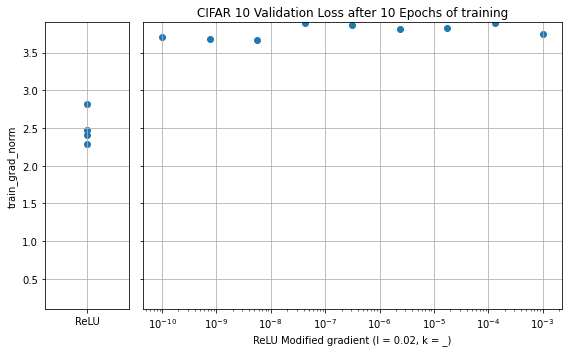

In [108]:
plot_logs_ke(*log_data_with_l(0.001),prop = "train_grad_norm", x_axis = 'epoch', title = "CIFAR 10 Validation Loss after 10 Epochs of training", 
             index = 2,
             x_label = "ReLU Modified gradient (l = 0.02, k = _)", i_cut = 38,
             x_scale = "log",
            baselines=[["ReLU"]*4,log_data[("gmodrelu",0,0)]]
            )

In [81]:
plot_logs_ke(*log_data_with_l(0.02),prop = "train_loss", x_axis = 'epoch', title = "CIFAR 10 Validation Loss after 10 Epochs of training", 
             index = 3,
             x_label = "ReLU Modified gradient (l = 0.02, k = _)", i_cut = 38,
             x_scale = "log",
             baselines=[["ReLU","ReLU","GeLU","GeLU","GeLU"],[*log_data[('gmodrelu', 0.02, 0.0)],*log_data['gelu']]])

KeyError: ('gmodrelu', 0.02, 0.0)

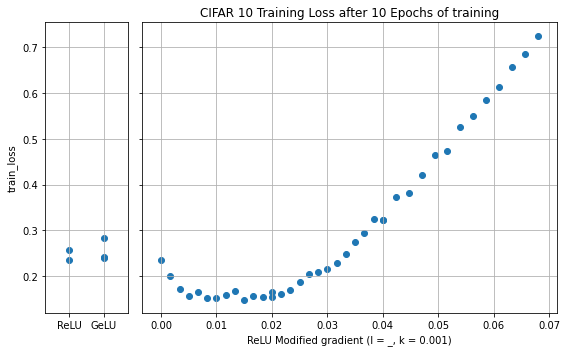

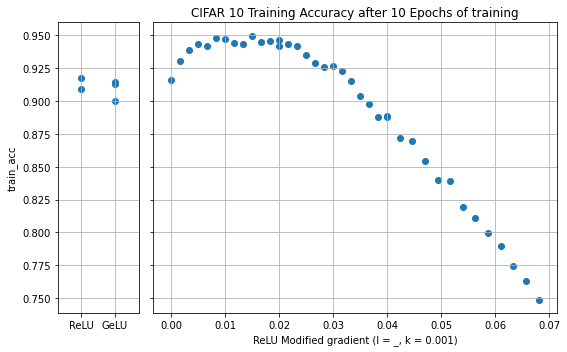

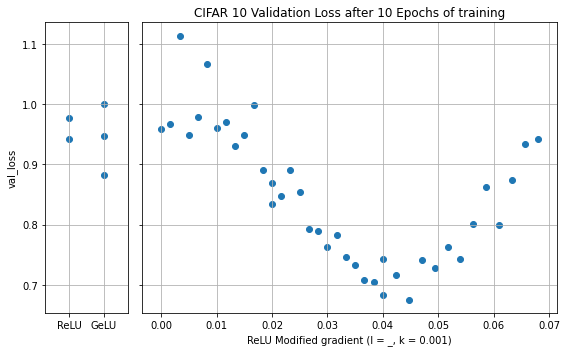

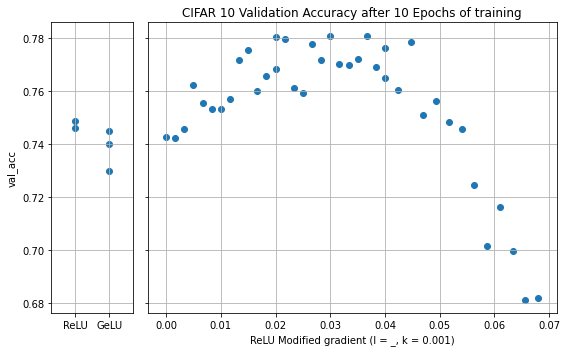

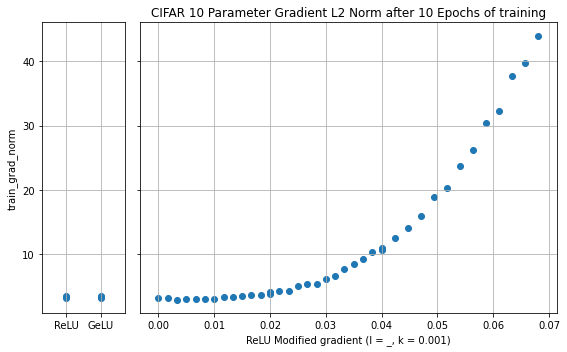

In [168]:
for prop, desc in [("train_loss","Training Loss"),("train_acc","Training Accuracy"),("val_loss","Validation Loss"), ("val_acc", "Validation Accuracy"), ("train_grad_norm", "Parameter Gradient L2 Norm")]:
    plot_logs_ke(*log_data_with_k(0.001),prop = prop, x_axis = 'epoch', i_cut = 39,
                  baselines=[["ReLU","ReLU","GeLU","GeLU","GeLU"],[*log_data[('gmodrelu', 0.02, 0.0)],*log_data['gelu']]],
                  title = f"CIFAR 10 {desc} after 10 Epochs of training",
                 x_label = "ReLU Modified gradient (l = _, k = 0.001)",
                 x_scale = "linear",
                 file_name = f"cifar_l_full_{prop}"
                )
            
# baselines=[["ReLU","ReLU","GeLU","GeLU","GeLU"],[*log_data[('gmodrelu', 0.02, 0.0)],*log_data['gelu']]

In [626]:
logs,keys = log_data_with_l(0.02)
logs[0].

dict_keys(['batches', 'train_loss', 'train_acc', 'train_grad_norm', 'train_weight_update_norm', 'val_loss', 'val_acc', 'trainloss', 0, 'loss'])

In [667]:
log_data.keys()

dict_keys([('gmodrelu', 0.02, 0.0), ('gmodrelu', 0.02, 0.0003), ('gmodrelu', 0.02, 0.003), ('gmodrelu', 0.02, 0.03), ('gmodrelu', 0.02, 0.3), ('gmodrelu', 0.02, 3.0), ('gmodrelu', 0.02, 5e-05), ('gmodrelu', 0.02, 0.0001), ('gmodrelu', 0.02, 0.001), 'gelu'])

In [28]:
prop = "train_loss"
plot_logs_k(*log_data_with_l(0.02), file_name = None,prop = prop, x_axis = 'epoch',i_cut = 50)
# for log in log_data['gelu']:
#     loss = np.array(log[prop])
#     # loss = extract_batch_metric(log, "train_loss")
#     plt.plot(loss, color = "red")
    

NameError: name 'plot_logs_k' is not defined

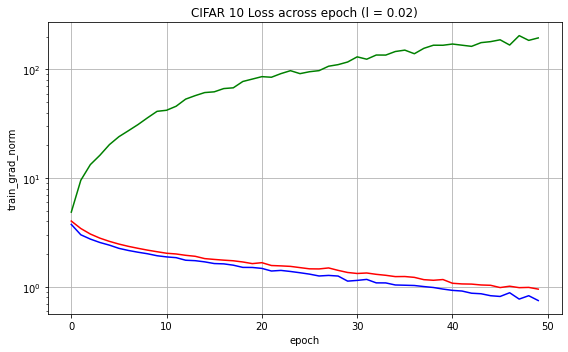

In [49]:
prop = "train_grad_norm"
plot_logs_k_col(*log_data_with_activations(["relu","gelu",('gmodrelu', 0.03, 0.001)],["red","blue","green"]), file_name = None,prop = prop, x_axis = 'epoch',i_cut = 50,y_scale = "log")
# for log in log_data['gelu']:
#     loss = np.array(log[prop])
#     # loss = extract_batch_metric(log, "train_loss")
#     plt.plot(loss, color = "red")
    

In [35]:
log_data_with_activation("relu")[1]

['relu']

In [10]:
import pickle

In [169]:
# Open a file and use dump() 
with open('log_data_small_cnn.pkl', 'wb') as file: 
    if len(log_data) == 0:
        print("Error: overwriting with empty")
    else:
        # A new file will be created 
        pickle.dump(log_data, file) 

In [371]:
logs_gmodrelus_1 = logs_gmodrelus

In [11]:
with open('log_data.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    log_data = pickle.load(file) 

In [385]:
l_vals_1 = test["l_vals"]
l_vals_1

array([0.        , 0.03333333, 0.06666667])